# Validation plots

In [1]:
import os
import pickle

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import baryon_painter.utils.datasets as datasets
import baryon_painter.painter
import baryon_painter.utils.validation_plotting as validation_plotting

In [2]:
machine = "arrakis"

if machine == "laptop":
    data_path = "../data/training_data/BAHAMAS/stacks_uncompressed/"
    output_path = "../output/"
    compute_device = "cpu"
    
elif machine == "arrakis":
    data_path = "../../painting_baryons/training_data/BAHAMAS/stacks_new/"
    output_path = "../output/"
    compute_device = "cuda:0"


In [3]:
with open(os.path.join(data_path, "train_files_info.pickle"), "rb") as f:
    training_files_info = pickle.load(f)

n_training_stack = 11
n_validation_stack = 3
 
n_scale = 1
n_aux_label = 1
label_fields = ["pressure"]
redshifts = [0.0, 0.125, 0.25, 0.375, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]

validation_dataset = datasets.BAHAMASDataset(files=training_files_info, root_path=data_path,
                                             redshifts=redshifts,
                                             label_fields=label_fields,
                                             n_stack=n_validation_stack, stack_offset=n_training_stack,
                                             n_feature_per_field=n_scale,
                                             mmap_mode="r",
                                             scale_to_SLICS=True,
                                            )

In [4]:
run_name = "single_scale_max_z2_no_z0.25_log_shift_softmax_lr1e-3"

painter = baryon_painter.painter.CVAEPainter((os.path.join(output_path, run_name, "model_state"),
                                              os.path.join(output_path, run_name, "model_meta")), 
                                             compute_device=compute_device)


CVAE with Type-1 architecture.


Redshift z=0.0


/home/ttroester/miniconda/envs/torch/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/ttroester/Research/cosmotools/cosmotools/power_spectrum_tools.py:82: RuntimeWarning: invalid value encountered in sqrt
  k_grid = np.sqrt(sum(k**2 for k in k_mesh))


Redshift z=0.25
Redshift z=0.5


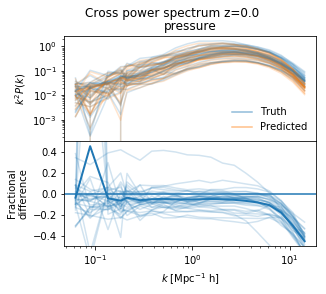

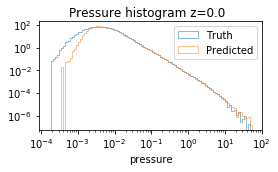

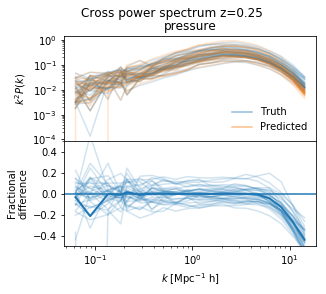

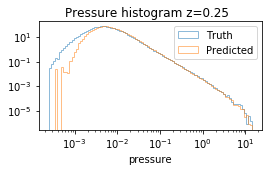

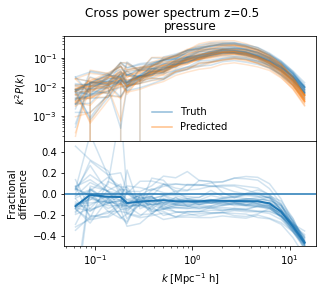

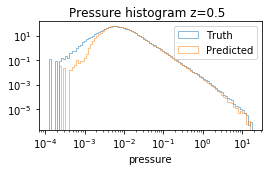

In [5]:
n_sample = 32
validation_redshifts = [0.0, 0.25, 0.5]

for z in validation_redshifts:
    print(f"Redshift z={z}")
    samples, idx, redshifts = validation_dataset.get_batch(size=n_sample, z=z)

    dm = []
    pressure_truth = []
    pressure_fake = []
    for i in range(n_sample):
        in_ = samples[0,i]
        truth = samples[1,i]        
        out = painter.paint(in_, z=redshifts[i], transform=True, inverse_transform=True)
        
        dm.append(in_)
        pressure_truth.append(truth)
        pressure_fake.append(out)

        
    dm = np.array(dm)
    pressure_truth = np.array(pressure_truth)
    pressure_fake = np.array(pressure_fake)
    
#     fig, ax = validation_plotting.plot_power_spectra(output_true=pressure_truth[:,None,...], 
#                                                            input=dm[:,None,...], 
#                                                            output_pred=pressure_fake[:,None,...],
#                                                            L=validation_dataset.tile_L,
#                                                            output_labels=validation_dataset.label_fields,
#                                                            mode="auto",
#                                                            n_feature_per_field=validation_dataset.n_feature_per_field,
#                                                            plot_size=(5,2))
#     fig.suptitle(f"Auto power spectrum z={z}")
    
    fig, ax = validation_plotting.plot_power_spectra(output_true=pressure_truth[:,None,...], 
                                                           input=dm[:,None,...], 
                                                           output_pred=pressure_fake[:,None,...],
                                                           L=validation_dataset.tile_L,
                                                           output_labels=validation_dataset.label_fields,
                                                           mode="cross",
                                                           n_feature_per_field=validation_dataset.n_feature_per_field,
                                                           plot_size=(5,2))
        
    fig.suptitle(f"Cross power spectrum z={z if z is not None else 'all'}")
    
    fig, ax = validation_plotting.plot_histogram(output_true=pressure_truth[:,None,...], 
                                                 output_pred=pressure_fake[:,None,...], 
                                                 n_sample=4, 
                                                 labels=validation_dataset.label_fields, 
                                                 plot_size=(4,2), 
                                                 y_logscale=True, x_logscale=True,
                                                 histtype="step")
    fig.suptitle(f"Pressure histogram z={z if z is not None else 'all'}")
                 
    
    
    